## pytorchでauto encoderを実装する (入力はMNIST)

In [20]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from matplotlib import pyplot as plt
%matplotlib inline

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')
    
num_epochs = 20
batch_size = 128
learning_rate = 0.001
out_dir = './result/autoencoder'

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0,1] => [-1,1]
])
train_dataset = MNIST('./data', download=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
if cuda:
    model.cuda()

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

loss_list = []

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        x = img.view(img.size(0), -1)
        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)
        
        xhat = model(x)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss.item()))
    loss_list.append(loss.item())

    # 10エポックごとに再構成された画像（xhat）を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.cpu().data)
        save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))

np.save('./{}/loss_list.npy'.format(out_dir), np.array(loss_list))
torch.save(model.state_dict(), './{}/autoencoder.pth'.format(out_dir))

epoch [1/20], loss: 0.1870
epoch [2/20], loss: 0.1788
epoch [3/20], loss: 0.1820
epoch [4/20], loss: 0.1647
epoch [5/20], loss: 0.1812
epoch [6/20], loss: 0.1645
epoch [7/20], loss: 0.1680
epoch [8/20], loss: 0.1588
epoch [9/20], loss: 0.1648
epoch [10/20], loss: 0.1583
epoch [11/20], loss: 0.1665
epoch [12/20], loss: 0.1452
epoch [13/20], loss: 0.1610
epoch [14/20], loss: 0.1543
epoch [15/20], loss: 0.1435
epoch [16/20], loss: 0.1602
epoch [17/20], loss: 0.1452
epoch [18/20], loss: 0.1635
epoch [19/20], loss: 0.1446
epoch [20/20], loss: 0.1499


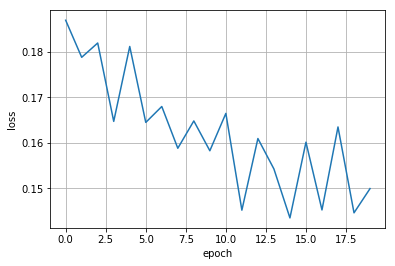

In [9]:
loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

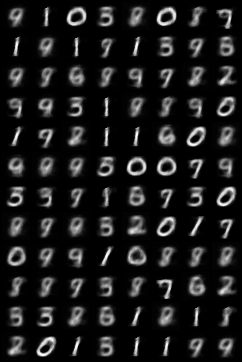

In [16]:
from IPython.display import Image
Image('result/autoencoder/image_0.png')

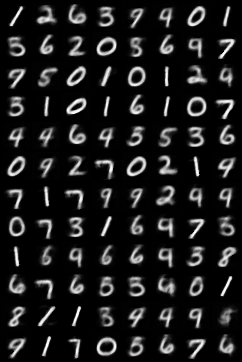

In [17]:
Image("result/autoencoder/image_{}.png".format(num_epochs))

In [21]:
model.load_state_dict(torch.load('{}/autoencoder.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))

test_dataset = MNIST('./data', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

images, labels = iter(test_loader).next()
print(images.size())
images = images.view(10000, -1)

# 784次元ベクトルを2次元ベクトルにencode
z = model.encoder(Variable(images)).data.numpy()

torch.Size([10000, 1, 28, 28])


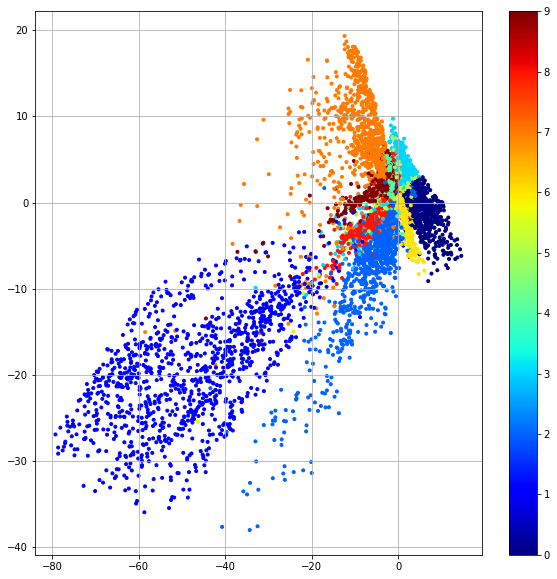

In [24]:
import pylab


plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid()